In [1]:
from sklearn import datasets
from matplotlib import pyplot

In [2]:
# TODO: wczytać MNIST
digits = datasets.load_digits()

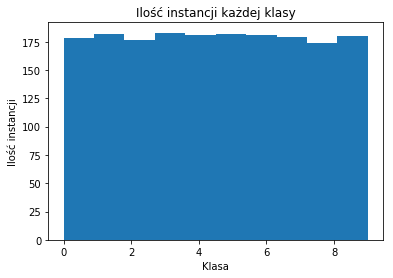

In [3]:
pyplot.title("Ilość instancji każdej klasy")
pyplot.xlabel("Klasa")
pyplot.ylabel("Ilość instancji")
pyplot.hist(digits.target, bins=len(digits.target_names))
pyplot.show()
